<a href="https://colab.research.google.com/github/sespezua/cursos/blob/master/Projeto_10_Regress%C3%A3o_venda_de_v%C3%ADdeo_games.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Projeto 10: Regressão venda de vídeo games





## Etapa 1: Importação das bibliotecas

In [ ]:
import pandas as pd
import torch
from torch import nn, optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
torch.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'1.4.0'

## Etapa 2: Base de dados

In [ ]:
torch.manual_seed(123)

In [ ]:
base = pd.read_csv('games.csv')

In [ ]:
base.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
base.shape

(16719, 16)

In [ ]:
base = base.drop('Other_Sales', axis = 1)
base = base.drop('Global_Sales', axis = 1)
base = base.drop('Developer', axis = 1)

In [ ]:
base.shape

(16719, 13)

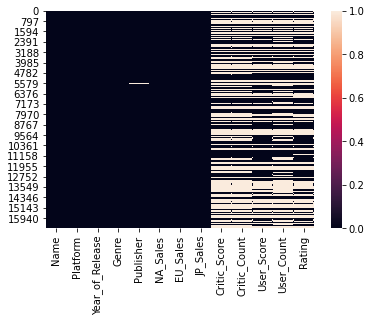

In [ ]:
sns.heatmap(base.isnull());

In [ ]:
base = base.dropna(axis = 0)

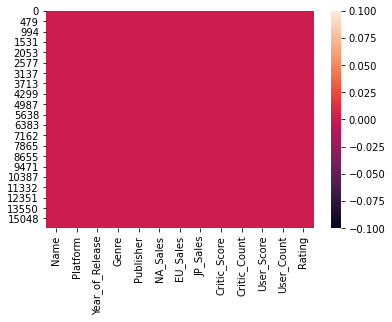

In [ ]:
sns.heatmap(base.isnull());

In [ ]:
base.shape

(6825, 13)

In [ ]:
base.loc[base['NA_Sales'] > 1]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,80.0,73.0,8,192.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,89.0,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1872,NCAA Football 14,X360,2013.0,Sports,Electronic Arts,1.01,0.00,0.00,77.0,18.0,5.8,74.0,E
1877,NFL 2K1,DC,2000.0,Sports,Sega,1.02,0.05,0.00,97.0,22.0,6,47.0,E
1881,Madden NFL 2004,XB,2003.0,Sports,Electronic Arts,1.02,0.02,0.00,92.0,27.0,8.3,48.0,E
1889,NCAA Football 13,X360,2012.0,Action,Electronic Arts,1.02,0.00,0.00,76.0,20.0,5.5,65.0,E


In [ ]:
base = base.loc[base['NA_Sales'] > 1]

In [ ]:
base.shape

(584, 13)

In [ ]:
base.loc[base['EU_Sales'] > 1]

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,76.0,51.0,8,322.0,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,80.0,73.0,8,192.0,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,89.0,65.0,8.5,431.0,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,58.0,41.0,6.6,129.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568,Medal of Honor,PS,1998.0,Shooter,Electronic Arts,1.44,1.09,0.00,92.0,17.0,8.6,80.0,T
573,Tom Clancy's Splinter Cell,PS2,2003.0,Action,Ubisoft,1.15,1.11,0.00,89.0,24.0,7.7,102.0,T
591,Mario Strikers Charged,Wii,2007.0,Sports,Nintendo,1.05,1.05,0.24,79.0,47.0,8,124.0,E10+
610,Crazy Taxi,PS2,2001.0,Racing,Acclaim Entertainment,1.13,1.12,0.06,80.0,15.0,7.9,46.0,T


In [ ]:
base = base.loc[base['EU_Sales'] > 1]

In [ ]:
base.shape

(258, 13)

In [ ]:
base['Name'].value_counts

<bound method IndexOpsMixin.value_counts of 0                      Wii Sports
2                  Mario Kart Wii
3               Wii Sports Resort
6           New Super Mario Bros.
7                        Wii Play
                  ...            
568                Medal of Honor
573    Tom Clancy's Splinter Cell
591        Mario Strikers Charged
610                    Crazy Taxi
636         The Sims: Bustin' Out
Name: Name, Length: 258, dtype: object>

In [ ]:
base = base.drop('Name', axis = 1)

In [ ]:
base.shape

(258, 12)

In [ ]:
previsores = base.iloc[:, [0, 1, 2, 3, 7, 8, 9, 10, 11]].values
vendas = base.iloc[:, 4:7].values

In [ ]:
previsores

array([['Wii', 2006.0, 'Sports', ..., '8', 322.0, 'E'],
       ['Wii', 2008.0, 'Racing', ..., '8.3', 709.0, 'E'],
       ['Wii', 2009.0, 'Sports', ..., '8', 192.0, 'E'],
       ...,
       ['Wii', 2007.0, 'Sports', ..., '8', 124.0, 'E10+'],
       ['PS2', 2001.0, 'Racing', ..., '7.9', 46.0, 'T'],
       ['PS2', 2003.0, 'Simulation', ..., '8.4', 42.0, 'T']], dtype=object)

In [ ]:
vendas

array([[4.136e+01, 2.896e+01, 3.770e+00],
       [1.568e+01, 1.276e+01, 3.790e+00],
       [1.561e+01, 1.093e+01, 3.280e+00],
       [1.128e+01, 9.140e+00, 6.500e+00],
       [1.396e+01, 9.180e+00, 2.930e+00],
       [1.444e+01, 6.940e+00, 4.700e+00],
       [9.710e+00, 7.470e+00, 4.130e+00],
       [8.920e+00, 8.030e+00, 3.600e+00],
       [1.500e+01, 4.890e+00, 2.400e-01],
       [9.010e+00, 8.490e+00, 2.530e+00],
       [7.020e+00, 9.090e+00, 9.800e-01],
       [4.740e+00, 9.200e+00, 4.160e+00],
       [9.660e+00, 5.140e+00, 6.000e-02],
       [8.410e+00, 5.490e+00, 4.700e-01],
       [3.430e+00, 5.350e+00, 5.320e+00],
       [6.850e+00, 5.090e+00, 1.870e+00],
       [9.040e+00, 4.240e+00, 1.300e-01],
       [9.700e+00, 3.680e+00, 1.100e-01],
       [4.990e+00, 5.730e+00, 6.500e-01],
       [8.250e+00, 4.240e+00, 7.000e-02],
       [8.520e+00, 3.590e+00, 8.000e-02],
       [5.540e+00, 5.730e+00, 4.900e-01],
       [6.990e+00, 4.510e+00, 3.000e-01],
       [6.620e+00, 2.550e+00, 2.66

In [ ]:
# Wii 1 0
# PS2 0 1
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
onehotencorder = ColumnTransformer(transformers=[("OneHot", OneHotEncoder(), [0, 2, 3, 8])], remainder='passthrough') 
previsores = onehotencorder.fit_transform(previsores).toarray()

In [ ]:
previsores.shape

(258, 61)

## Etapa 3: Construção do modelo

In [ ]:
# 61 -> 32 -> 32 -> 3
class regressor_torch(nn.Module):
    def __init__(self):
        super().__init__()
        self.dense0 = nn.Linear(61, 32)
        self.dense1 = nn.Linear(32, 32)
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(32, 3)
        
    def forward(self, X):
        X = self.dense0(X)
        X = self.activation(X)
        X = self.dense1(X)
        X = self.activation(X)
        X = self.output(X)
        return X

In [ ]:
regressor = regressor_torch()

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(regressor.parameters())

In [ ]:
type(previsores)

numpy.ndarray

In [ ]:
previsores = torch.tensor(previsores, dtype=torch.float)
vendas = torch.tensor(vendas, dtype=torch.float)

In [ ]:
type(previsores)

torch.Tensor

In [ ]:
dataset = torch.utils.data.TensorDataset(previsores, vendas)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 10, shuffle = True)

## Etapa 4: Treinamento do modelo

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
regressor.to(device)

regressor_torch(
  (dense0): Linear(in_features=61, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=32, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=32, out_features=3, bias=True)
)

In [ ]:
for epoch in range(2000):
    
    running_loss = 0.
    running_mse_0 = 0.
    running_mse_1 = 0.
    running_mse_2 = 0.
    
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
       
        optimizer.zero_grad()

        outputs = regressor(inputs)

        mse_0 = F.mse_loss(outputs[:,0], labels[:,0]).item()
        mse_1 = F.mse_loss(outputs[:,1], labels[:,1]).item()
        mse_2 = F.mse_loss(outputs[:,2], labels[:,2]).item()
        
        running_mse_0 += mse_0 * len(inputs)
        running_mse_1 += mse_1 * len(inputs)
        running_mse_2 += mse_2 * len(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        
        optimizer.step()

        loss = loss.item()
        running_loss += loss * len(inputs)

        print('\rÉpoca {:4d} - Loop {:3d} de {:3d}: erro_0 {:6.4f} | erro_1 {:6.4f} | erro_2 {:6.4f} - custo {:6.4f}'.format(epoch + 1,
                      i + 1,
                      len(train_loader),
                      mse_0,
                      mse_1,
                      mse_2,
                      loss), end = '\r')

    print('ÉPOCA {:4d} finalizada: erro_0 {:6.4f} | erro_1 {:6.4f} | erro_2 {:6.4f} - custo {:6.4f}         '.format(epoch + 1, 
         running_mse_0/len(dataset), 
         running_mse_1/len(dataset), 
         running_mse_2/len(dataset), 
         running_loss/len(dataset)))

ÉPOCA    1 finalizada: erro_0 8.1142 | erro_1 3.4189 | erro_2 0.7925 - custo 4.1085         
ÉPOCA    2 finalizada: erro_0 8.3427 | erro_1 3.4839 | erro_2 0.8993 - custo 4.2420         
ÉPOCA    3 finalizada: erro_0 8.4217 | erro_1 3.6036 | erro_2 0.9906 - custo 4.3386         
ÉPOCA    4 finalizada: erro_0 11.0630 | erro_1 5.3204 | erro_2 1.0902 - custo 5.8245         
ÉPOCA    5 finalizada: erro_0 8.9564 | erro_1 3.7704 | erro_2 0.8953 - custo 4.5407         
ÉPOCA    6 finalizada: erro_0 8.0196 | erro_1 3.5709 | erro_2 0.9014 - custo 4.1640         
ÉPOCA    7 finalizada: erro_0 8.0420 | erro_1 3.6712 | erro_2 0.9161 - custo 4.2098         
ÉPOCA    8 finalizada: erro_0 8.0353 | erro_1 3.5823 | erro_2 0.8976 - custo 4.1717         
ÉPOCA    9 finalizada: erro_0 7.8986 | erro_1 3.6648 | erro_2 0.9087 - custo 4.1574         
ÉPOCA   10 finalizada: erro_0 8.5069 | erro_1 3.6712 | erro_2 0.8623 - custo 4.3468         
ÉPOCA   11 finalizada: erro_0 8.0708 | erro_1 3.5346 | erro_2 0.8958 

## Etapa 5: Avaliação do modelo

In [ ]:
regressor.eval()

regressor_torch(
  (dense0): Linear(in_features=61, out_features=32, bias=True)
  (dense1): Linear(in_features=32, out_features=32, bias=True)
  (activation): Sigmoid()
  (output): Linear(in_features=32, out_features=3, bias=True)
)

In [ ]:
previsores = previsores.to(device)
previsoes = regressor.forward(previsores)

In [ ]:
previsoes

tensor([[3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.0135, 2.5465, 0.1490],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.3061, 2.3566, 0.6047],
        [3.306

In [ ]:
previsoes = previsoes.cpu().detach().numpy()

In [ ]:
previsoes

array([[3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.0134957 , 2.5465155 , 0.14904332],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.3061292 , 2.356576  , 0.6046584 ],
       [3.

In [ ]:
previsoes.mean(axis = 0)

array([3.2993295, 2.3609893, 0.5940639], dtype=float32)

In [ ]:
vendas.mean(axis = 0)

tensor([3.2838, 2.3505, 0.5862])

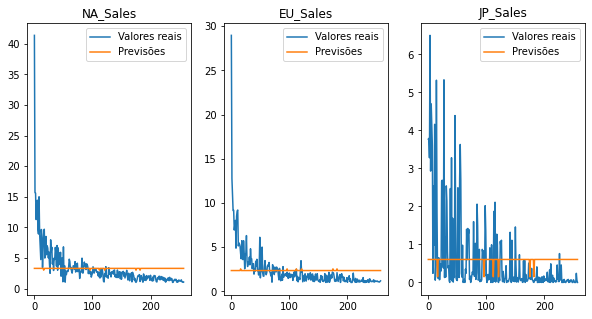

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(10,5))
for i in range(3):
  ax[i].plot(vendas[:, i])
  ax[i].plot(previsoes[:, i])
  ax[i].legend(['Valores reais', 'Previsões'])
  ax[i].set_title(base.columns[4 + i])